In [1]:
%pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, roc_auc_score)
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
%matplotlib inline

df = pd.read_parquet('../data/processed/model_ready_dataset.parquet')

In [3]:
# Seleccionamos features y variables objetivo
print("Seleccionando features")
print("="*60)

# Variable objetivo
target = 'teamA_won'

# Excluimos columnas que no son features
exclude_cols = ['Match Name', 'teamA_name', 'teamB_name', 'Team A', 'Team B', 'Match Result', 'teamA_won', 'year']

# Columnas numericas
all_features = [col for col in df.columns if col not in exclude_cols and df[col].dtype in ['float64', 'int64']]

print(f"\nFeatures seleccionados: {len(all_features)}")
print("\nLista de features:")

for i, feat in enumerate(all_features, 1):
    print(f"{i:2}. {feat}")

X = df[all_features].copy()
y = df[target].copy()

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nBalance del target:")
print(f"- teamA_won = 1: {y.sum():,} ({y.mean()*100:.1f}%)")
print(f"- teamA_won = 0: {(len(y)-y.sum()):,} ({(1-y.mean())*100:.1f}%)")

Seleccionando features

Features seleccionados: 30

Lista de features:
 1. teamA_kills
 2. teamA_deaths
 3. teamA_assists
 4. teamA_acs
 5. teamA_rating
 6. teamA_first_kills
 7. teamA_first_deaths
 8. teamA_kd
 9. teamA_ka
10. teamA_fkfd_diff
11. teamB_kills
12. teamB_deaths
13. teamB_assists
14. teamB_acs
15. teamB_rating
16. teamB_first_kills
17. teamB_first_deaths
18. teamB_kd
19. teamB_ka
20. teamB_fkfd_diff
21. diff_kills
22. diff_deaths
23. diff_assists
24. diff_acs
25. diff_rating
26. diff_first_kills
27. diff_first_deaths
28. diff_kd
29. diff_ka
30. diff_fkfd_diff

X shape: (8617, 30)
y shape: (8617,)

Balance del target:
- teamA_won = 1: 4,433 (51.4%)
- teamA_won = 0: 4,184 (48.6%)


In [4]:
# Revisamos y limpiamos valores nulos

print("Revisando valores nulos")
print("="*60)

nulls = X.isnull().sum()
null_pct = (nulls / len(X)) * 100

cols_with_nulls = nulls[nulls > 0]

if len(cols_with_nulls) > 0:
    print(f"\nColumnas con valores nulos:")
    for col in cols_with_nulls.index:
        print(f"- {col}: {nulls[col]:,} nulos ({null_pct[col]:.1f}%)")

else:
    print("\nNo hay valores nulos")

# Si existen nulos rellenamos los valores con la mediana
print("\nRellenando nulos con la mediana...")

X = X.fillna(X.median())

# Verificamos que no quedan nulos
remaining_nulls = X.isnull().sum().sum()
print(f"Nulos restantes: {remaining_nulls}")
print(f"\nX final: {X.shape[0]:,} filas x {X.shape[1]} columnas")

Revisando valores nulos

Columnas con valores nulos:
- teamA_acs: 2 nulos (0.0%)
- teamA_rating: 1,824 nulos (21.2%)
- teamB_acs: 2 nulos (0.0%)
- teamB_rating: 1,824 nulos (21.2%)
- diff_acs: 2 nulos (0.0%)
- diff_rating: 1,824 nulos (21.2%)

Rellenando nulos con la mediana...
Nulos restantes: 0

X final: 8,617 filas x 30 columnas


- TRAIN (80%): El modelo aprende con estos datos
- TEST (20%):  Evaluamos qué tan bien predice con datos nuevos

In [5]:
# Dividimos datos en train y test

print("Dividiendo datos en train/test")
print("="*60)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 42,
    stratify = y
)


print(f"Split completado:")
print(f"\n- TRAIN: {len(X_train):,} partidos ({len(X_train)/len(X)*100:.0f}%)")
print(f"Balance: {y_train.mean()*100:.1f}% / {(1-y_train.mean())*100:.1f}%")
print(f"\n- TEST:  {len(X_test):,} partidos ({len(X_test)/len(X)*100:.0f}%)")
print(f"Balance: {y_test.mean()*100:.1f}% / {(1-y_test.mean())*100:.1f}%")

Dividiendo datos en train/test
Split completado:

- TRAIN: 6,893 partidos (80%)
Balance: 51.4% / 48.6%

- TEST:  1,724 partidos (20%)
Balance: 51.5% / 48.5%


Si Logistic Regression logra 70% de accuracy,
cualquier modelo más complejo DEBE superar ese 70%.
Si no lo supera, algo está mal.

In [6]:
# Entrenamos el modelo baseline (Logistic Regresion)

print("Entrenamos Logistic Regression")
print("="*60)

print("\nEscalando datos...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Datos escalados")

# Escalamos los datos para que todos los valores esten en la misma escala
# Entrenando el modelo
print("\nEntrenando modelo...")

lr_model = LogisticRegression(random_state = 42, max_iter = 1000)
lr_model.fit(X_train_scaled, y_train)
print("\nModelo enrenado")

# Predecir en test
y_pred = lr_model.predict(X_test_scaled)
y_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# Metricas
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\nResultados en test:")
print(f"- Accuracy: {accuracy*100:.1f}%")
print(f"- ROC-AUC: {roc_auc: .3f}")

Entrenamos Logistic Regression

Escalando datos...
Datos escalados

Entrenando modelo...

Modelo enrenado

Resultados en test:
- Accuracy: 94.2%
- ROC-AUC:  0.984


Visualizando resultados


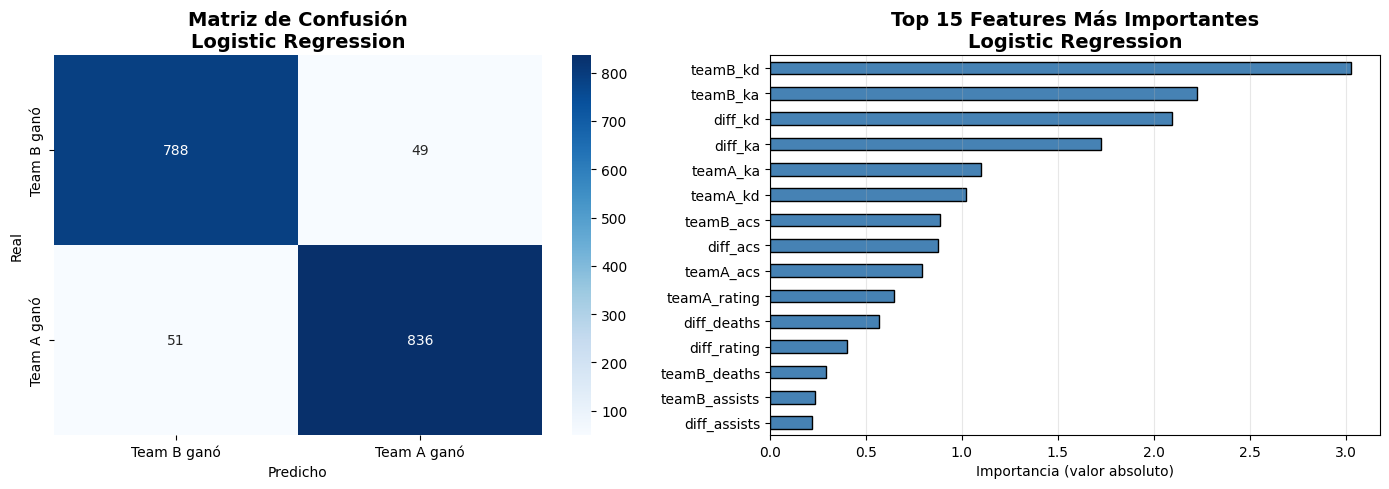


REPORTE COMPLETO:
              precision    recall  f1-score   support

 Team B ganó       0.94      0.94      0.94       837
 Team A ganó       0.94      0.94      0.94       887

    accuracy                           0.94      1724
   macro avg       0.94      0.94      0.94      1724
weighted avg       0.94      0.94      0.94      1724



In [7]:
print("Visualizando resultados")
print("=" * 60)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Team B ganó', 'Team A ganó'],
            yticklabels=['Team B ganó', 'Team A ganó'])
axes[0].set_title('Matriz de Confusión\nLogistic Regression', 
                   fontsize=14, fontweight='bold')
axes[0].set_ylabel('Real')
axes[0].set_xlabel('Predicho')

# Gráfico 2: Feature Importance
coefficients = pd.Series(lr_model.coef_[0], index=all_features)
coefficients_sorted = coefficients.abs().sort_values(ascending=True).tail(15)

coefficients_sorted.plot(kind='barh', ax=axes[1], 
                          color='steelblue', edgecolor='black')
axes[1].set_title('Top 15 Features Más Importantes\nLogistic Regression', 
                   fontsize=14, fontweight='bold')
axes[1].set_xlabel('Importancia (valor absoluto)')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Reporte completo
print("\nREPORTE COMPLETO:")
print(classification_report(y_test, y_pred, 
                             target_names=['Team B ganó', 'Team A ganó']))

- Crea MUCHOS árboles de decisión (por defecto 100)
- Cada árbol aprende algo diferente
- La predicción final es la "votación" de todos los árboles
- Generalmente más preciso que Logistic Regression

In [8]:
# Entrenamos el modelo Random Forest
print("Entrenando random forest")
print("="*60)

print("\nEntrenando modelo...")

rf_model = RandomForestClassifier(
    n_estimators = 100,
    random_state = 42,
    n_jobs = 1
)

rf_model.fit(X_train, y_train)
print("Modelo entrenado")

# Predecir
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Metricas
accuracy_rf = accuracy_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

print("\n Resultados Random Forest:")
print(f"- Accuracy: {accuracy_rf*100: .1f}%")
print(f"- ROC-AUC: {roc_auc_rf: .3f}")

Entrenando random forest

Entrenando modelo...
Modelo entrenado

 Resultados Random Forest:
- Accuracy:  93.5%
- ROC-AUC:  0.982


Comparando los dos modelos

Comparación de modelos

Tabla comparativa:


,Modelo,Accuracy,ROC-AUC
0,Logistic Regression,94.199536,0.984036
1,Random Forest,93.503480,0.981668


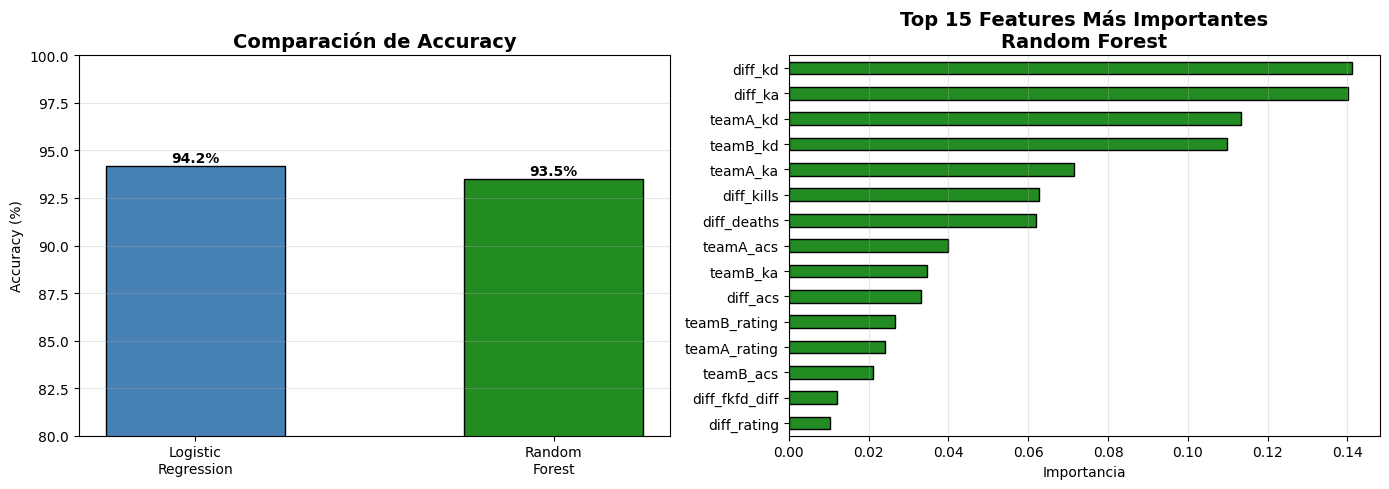


Reporte random forest:
              precision    recall  f1-score   support

 Team B ganó       0.93      0.93      0.93       837
 Team A ganó       0.94      0.94      0.94       887

    accuracy                           0.94      1724
   macro avg       0.93      0.94      0.93      1724
weighted avg       0.94      0.94      0.94      1724


Conclusión

   - Mejor modelo: Logistic Regression
   - Accuracy: 94.2%



In [9]:
print("Comparación de modelos")
print("=" * 60)

# Tabla comparativa
results = pd.DataFrame({
    'Modelo': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [accuracy*100, accuracy_rf*100],
    'ROC-AUC': [roc_auc, roc_auc_rf]
})

print("\nTabla comparativa:")
display(results)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Comparar Accuracy
axes[0].bar(['Logistic\nRegression', 'Random\nForest'],
            [accuracy*100, accuracy_rf*100],
            color=['steelblue', 'forestgreen'],
            edgecolor='black', width=0.5)
axes[0].set_title('Comparación de Accuracy', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_ylim([80, 100])
axes[0].axhline(y=50, color='red', linestyle='--', label='Modelo aleatorio (50%)')
for i, v in enumerate([accuracy*100, accuracy_rf*100]):
    axes[0].text(i, v + 0.2, f'{v:.1f}%', ha='center', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Gráfico 2: Feature Importance del Random Forest
feat_importance = pd.Series(
    rf_model.feature_importances_, 
    index=all_features
).sort_values(ascending=True).tail(15)

feat_importance.plot(kind='barh', ax=axes[1], 
                     color='forestgreen', edgecolor='black')
axes[1].set_title('Top 15 Features Más Importantes\nRandom Forest', 
                   fontsize=14, fontweight='bold')
axes[1].set_xlabel('Importancia')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Reporte Random Forest
print("\nReporte random forest:")
print(classification_report(y_test, y_pred_rf,
                             target_names=['Team B ganó', 'Team A ganó']))

# Conclusión
print("\n" + "=" * 60)
print("Conclusión")
print("=" * 60)

mejor_modelo = 'Random Forest' if accuracy_rf > accuracy else 'Logistic Regression'
mejor_accuracy = max(accuracy_rf*100, accuracy*100)

print(f"""
   - Mejor modelo: {mejor_modelo}
   - Accuracy: {mejor_accuracy:.1f}%
""")

In [10]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


- Aprende de los errores de árboles anteriores
- Generalmente supera a Random Forest

In [11]:
# Entrenamos XGBoost
from xgboost import XGBClassifier

print("Entrenando XGBOOST")
print("="*60)
print("\nEntrenando modelo...")

xgb_model = XGBClassifier(
    n_estimators = 100,
    random_state = 42,
    eval_metric = 'logloss',
    verbosity = 0
)

xgb_model.fit(X_train, y_train)
print("Modelo entrenado")

# Predecir
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Metricas
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

print("\n Resultados xgboost")
print(f"- Accuracy: {accuracy_xgb*100: .1f}%")
print(f"- ROC-AUC: {roc_auc_xgb: .3f}")

Entrenando XGBOOST

Entrenando modelo...
Modelo entrenado

 Resultados xgboost
- Accuracy:  92.9%
- ROC-AUC:  0.980


Comparación final de los 3 modelos

Tabla comparativa:


,Modelo,Accuracy (%),ROC-AUC
0,Logistic Regression,94.200,0.984
1,Random Forest,93.503,0.982
2,XGBoost,92.865,0.980


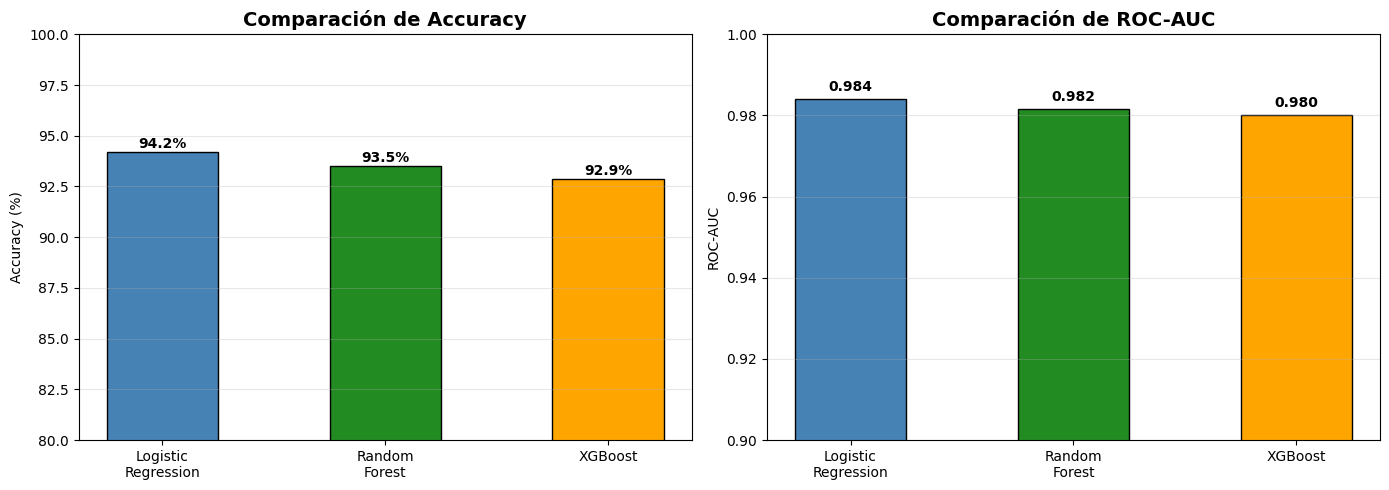


Conclusión final

    Mejor modelo: Logistic Regression
    Accuracy: 94.2%
    ROC-AUC: 0.984



In [12]:
print("Comparación final de los 3 modelos")
print("=" * 60)

# Tabla comparativa
results_final = pd.DataFrame({
    'Modelo': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy (%)': [accuracy*100, accuracy_rf*100, accuracy_xgb*100],
    'ROC-AUC': [roc_auc, roc_auc_rf, roc_auc_xgb]
}).round(3)

print("\nTabla comparativa:")
display(results_final)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colores = ['steelblue', 'forestgreen', 'orange']
modelos = ['Logistic\nRegression', 'Random\nForest', 'XGBoost']
accuracies = [accuracy*100, accuracy_rf*100, accuracy_xgb*100]
roc_aucs = [roc_auc, roc_auc_rf, roc_auc_xgb]

# Gráfico 1: Accuracy
bars = axes[0].bar(modelos, accuracies, color=colores, edgecolor='black', width=0.5)
axes[0].set_title('Comparación de Accuracy', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_ylim([80, 100])
for i, v in enumerate(accuracies):
    axes[0].text(i, v + 0.2, f'{v:.1f}%', ha='center', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Gráfico 2: ROC-AUC
axes[1].bar(modelos, roc_aucs, color=colores, edgecolor='black', width=0.5)
axes[1].set_title('Comparación de ROC-AUC', fontsize=14, fontweight='bold')
axes[1].set_ylabel('ROC-AUC')
axes[1].set_ylim([0.9, 1.0])
for i, v in enumerate(roc_aucs):
    axes[1].text(i, v + 0.002, f'{v:.3f}', ha='center', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Conclusión final
mejor_idx = accuracies.index(max(accuracies))
mejor_nombre = ['Logistic Regression', 'Random Forest', 'XGBoost'][mejor_idx]

print("\n" + "=" * 60)
print("Conclusión final")
print("=" * 60)
print(f"""
    Mejor modelo: {mejor_nombre}
    Accuracy: {max(accuracies):.1f}%
    ROC-AUC: {roc_aucs[mejor_idx]:.3f}
""")

In [13]:
import pickle
import os

print("Guardando mejor modelo")
print("=" * 60)

# Crear carpeta
os.makedirs('../models/saved_models/', exist_ok=True)

# Guardar Logistic Regression (el mejor)
with open('../models/saved_models/best_model_lr.pkl', 'wb') as f:
    pickle.dump(lr_model, f)

# Guardar el scaler (necesario para usar el modelo)
with open('../models/saved_models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Guardar lista de features (para saber qué columnas usar)
with open('../models/saved_models/features.pkl', 'wb') as f:
    pickle.dump(all_features, f)

print("Archivos guardados:")
print("- best_model_lr.pkl  → El modelo entrenado")
print("- scaler.pkl         → El escalador de datos")
print("- features.pkl       → Lista de features usadas")


# Verificar que se guardaron
for filename in ['best_model_lr.pkl', 'scaler.pkl', 'features.pkl']:
    path = f'../models/saved_models/{filename}'
    size = os.path.getsize(path) / 1024
    print(f" {filename}: {size:.1f} KB")

Guardando mejor modelo
Archivos guardados:
- best_model_lr.pkl  → El modelo entrenado
- scaler.pkl         → El escalador de datos
- features.pkl       → Lista de features usadas
 best_model_lr.pkl: 0.9 KB
 scaler.pkl: 1.6 KB
 features.pkl: 0.5 KB


- El mejor modelo es Logistic Regression:
    - Accuracy:  94.2%
    - ROC-AUC:   0.984
    - Partidos en test: 1,724
    - Aciertos: ~1,624 de 1,724

1. Features más importantes:
       KD Ratio (teamB_kd, diff_kd)
       KA Ratio (teamB_ka, diff_ka)  
       ACS (teamA_acs, teamB_acs)

2. Los modelos más simples ganaron:
      Logistic Regression > Random Forest > XGBoost
      Esto indica que la relación entre features y 
      resultado es bastante lineal

In [14]:
# Demo: cómo usar el modelo con un partido nuevo
print("DEMO: Predicción de un partido nuevo")
print("=" * 60)

# Tomar un partido real del test set
sample = X_test.iloc[0:1].copy()
real_result = y_test.iloc[0]

# Predecir
sample_scaled = scaler.transform(sample)
prediction = lr_model.predict(sample_scaled)[0]
probability = lr_model.predict_proba(sample_scaled)[0]

match_info = df.loc[X_test.index[0]]

print(f"""
Partido: {match_info['Match Name']}
   - {match_info['teamA_name']} vs {match_info['teamB_name']}

Predicción del modelo:
   - Ganador predicho: {'Team A (' + match_info['teamA_name'] + ')' if prediction == 1 else 'Team B (' + match_info['teamB_name'] + ')'}
   - Probabilidad Team A: {probability[1]*100:.1f}%
   - Probabilidad Team B: {probability[0]*100:.1f}%

Resultado real:
   - {'Team A (' + match_info['teamA_name'] + ') ganó' if real_result == 1 else 'Team B (' + match_info['teamB_name'] + ') ganó'}
   - Predicción: {'CORRECTA' if prediction == real_result else 'INCORRECTA'}
""")

DEMO: Predicción de un partido nuevo

Partido: azzi's anime aimers vs Munich-eSports Academy
   - Munich-eSports Academy vs azzi's anime aimers

Predicción del modelo:
   - Ganador predicho: Team B (azzi's anime aimers)
   - Probabilidad Team A: 0.0%
   - Probabilidad Team B: 100.0%

Resultado real:
   - Team B (azzi's anime aimers) ganó
   - Predicción: CORRECTA

